In [5]:
# Import dependencies
import twitter_functions as tf # custom functions file

from nltk.featstruct import _default_fs_class
import twitter_functions as tf # custom functions file
import streamlit as st
from streamlit_metrics import metric, metric_row
from PIL import Image
import pandas as pd
import datetime as dt
import base64
import tweepy as tw
import yaml
import string
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import altair as alt
import gensim
from gensim.utils import simple_preprocess

[nltk_data] Downloading package stopwords to C:\Users\S
[nltk_data]     Lo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
#-----------------------------------#
# 3) GET DATA FROM TWITTER API
#-----------------------------------#

## Set up Twitter API access
# Reference: https://gist.github.com/radcliff/47af9f6238c95f6ae239
# Load yml file to dictionary
credentials = yaml.load(open('./credentials.yml'), Loader=yaml.FullLoader)

# Define access keys and tokens
consumer_key = credentials['twitter_api']['consumer_key']
consumer_secret = credentials['twitter_api']['consumer_secret']
access_token = credentials['twitter_api']['access_token']
access_token_secret = credentials['twitter_api']['access_token_secret']

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

# define parameters for API request
search_word = "#rstats"
num_of_tweets = 300
include_retweets = False
language = "en"

if include_retweets == False:
    search_word = search_word + " -filter:retweets"

tweets = tw.Cursor(api.search,
                    q=search_word,
                    tweet_mode = "extended",
                    lang=language).items(num_of_tweets)

tweet_metadata = [[tweet.created_at, tweet.id, tweet.full_text, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Store as dataframe
df_tweets = pd.DataFrame(data=tweet_metadata, columns=['created_at', 'id', 'full_text', 'user', 'rt_count', 'fav_count'])

# Add a new data variable
df_tweets['created_dt'] = df_tweets['created_at'].dt.date

# Add a new time variable
df_tweets['created_time'] = df_tweets['created_at'].dt.time

# Create a new text variable to do manipulations on 
df_tweets['clean_text'] = df_tweets.full_text

# Run function #2: Feature extraction
df_tweets = tf.feature_extract(df_tweets)

# Run function #3: Round 1 text cleaning (convert to lower, remove numbers, @, punctuation, numbers. etc.)
df_tweets['clean_text'] = df_tweets.clean_text.apply(tf.text_clean_round1)

# Run function #4: Round 2 text cleaning (create list of tokenized words)
#TODO NOT RUNNING -- FIX?
#df_tweets.clean_text  = tf.text_clean_round2(df_tweets.clean_text)

## Run function #5: Round 3 text cleaning (remove stop words)
df_tweets.clean_text  = tf.text_clean_round3(df_tweets.clean_text)

# Create list of words
words2 = df_tweets.clean_text.tolist()

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Method 1

In [8]:
# Reference: https://ourcodingclub.github.io/tutorials/topic-modelling-python/
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df_tweets['clean_text']).toarray()

# tf_feature_names tells us what word each column in the matrix represents
tf_feature_names = vectorizer.get_feature_names()

print(tf_feature_names)

['100daysofcode', 'analytics', 'bigdata', 'cloudcomputing', 'codenewbie', 'coding', 'data', 'datascience', 'datascientist', 'iiot', 'iot', 'java', 'javascript', 'linux', 'machinelearning', 'programming', 'python', 'r', 'reactjs', 'serverless', 'tensorflow', 'tidyverse', 'womenwhocode']
C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<ipython-input-8-9ceac35fb486>:3: DeprecationWarning: invalid escape sequence \w
  vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+'

In [9]:
number_of_topics = 10

model = LDA(n_components=number_of_topics, random_state=0)

model.fit(tf)

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(random_state=0)

In [10]:
def lda_topics(data, number_of_topics):
    # the vectorizer object will be used to transform text to vector form
    vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

    # apply transformation
    tf = vectorizer.fit_transform(data).toarray()

    # tf_feature_names tells us what word each column in the matrix represents
    tf_feature_names = vectorizer.get_feature_names()

    model = LDA(n_components=number_of_topics, random_state=0)

    return model.fit(tf)

lda_topics(df_tweets['clean_text'], 10)

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<ipython-input-10-315aa601576b>:3: DeprecationWarning: invalid escape sequence \w
  vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')


LatentDirichletAllocation(random_state=0)

In [11]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,python,12.6,r,36.1,datascience,0.1,machinelearning,22.3,programming,23.4,datascience,0.1,tidyverse,47.1,python,52.3,data,48.1,datascience,24.0
1,analytics,8.1,datascience,8.9,python,0.1,python,22.0,machinelearning,15.9,python,0.1,r,12.1,datascience,50.5,coding,1.2,python,5.1
2,bigdata,7.3,programming,3.1,javascript,0.1,100daysofcode,20.9,iot,14.7,javascript,0.1,coding,0.1,bigdata,50.3,python,0.1,100daysofcode,3.1
3,machinelearning,7.0,machinelearning,0.1,coding,0.1,datascience,20.8,javascript,14.5,coding,0.1,javascript,0.1,analytics,50.1,programming,0.1,serverless,3.1
4,iot,5.0,python,0.1,programming,0.1,javascript,19.6,womenwhocode,13.8,programming,0.1,data,0.1,100daysofcode,48.3,analytics,0.1,tensorflow,2.1
5,datascience,4.7,data,0.1,machinelearning,0.1,codenewbie,15.1,python,13.5,machinelearning,0.1,datascience,0.1,iot,48.2,datascience,0.1,analytics,2.1
6,iiot,4.1,analytics,0.1,100daysofcode,0.1,womenwhocode,11.4,100daysofcode,13.4,100daysofcode,0.1,python,0.1,machinelearning,48.2,100daysofcode,0.1,data,0.1
7,reactjs,3.1,javascript,0.1,analytics,0.1,serverless,10.7,serverless,13.4,analytics,0.1,programming,0.1,reactjs,45.4,r,0.1,datascientist,0.1
8,100daysofcode,1.8,coding,0.1,iot,0.1,iot,10.4,bigdata,12.6,iot,0.1,machinelearning,0.1,javascript,45.2,reactjs,0.1,javascript,0.1
9,womenwhocode,0.1,100daysofcode,0.1,reactjs,0.1,cloudcomputing,6.1,linux,11.9,reactjs,0.1,100daysofcode,0.1,coding,45.0,machinelearning,0.1,coding,0.1


# Method 2

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


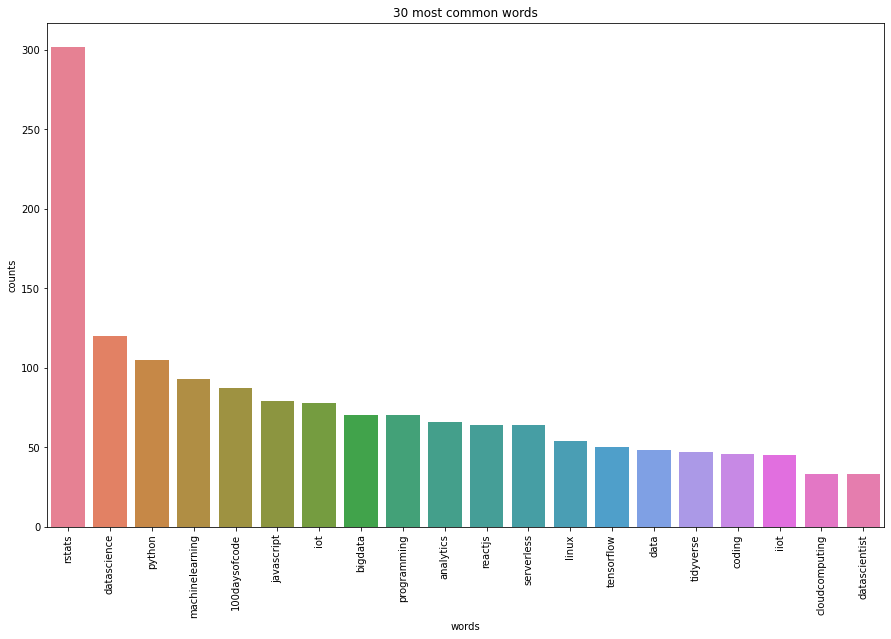

In [12]:
# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed transcripts
count_data = count_vectorizer.fit_transform(df_tweets['clean_text'])

# Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

In [13]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 30
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Topics found via LDA:

Topic #0:
rstats tidyverse data using datascience repository science create runiverse personal cranlike open function error argument rmarkdown analysis gt rbloggers variable tools ggplot2 teaching use makes point miss names beginning thousands

Topic #1:
rstats data amp video package online new community learning club book using animation regression financial ros01 stories chapter support dplyr fun dataviz provides building loop heights dem explaining nest line

Topic #2:
rstats python datascience machinelearning iot 100daysofcode bigdata javascript programming serverless reactjs anal

Reference: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
data_words = list(sent_to_words(df_tweets['clean_text']))

print(data_words[:1][0][:30])

['come', 'hear', 'developers', 'guide', 'contributing', 'rstats', 'developing', 'support', 'great', 'session']
C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-06-22 00:22:28.599 INFO    gensim.corpora.dictionary: adding document #0 to Dictionary(0 unique tokens: [])
2021-06-22 00:22:28.631 INFO    gensim.corpora.dictionary: built Dictionary(1607 unique tokens: ['come', 'contributing', 'developers', 'developing', 'great']...) from 300 documents (total 4579 corpus positions)
2021-06-22 00:22:28.634 INFO    gensim.utils: Dictionary lifecycle event {'msg': "built Dictionary(1607 unique tokens: ['come', 'contributing', 'developers', 'developing', 'great']...) from 300 documents (total 4579 corpus positions)", 'datetime': '2021-06-22T00:22:28.633335', 'gensim': '4

In [17]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-06-22 00:22:28.678 INFO    gensim.models.ldamodel: using symmetric alpha at 0.1
2021-06-22 00:22:28.679 INFO    gensim.models.ldamodel: using symmetric eta at 0.1
2021-06-22 00:22:28.681 INFO    gensim.models.ldamodel: using serial LDA version on this node
2021-06-22 00:22:28.685 INFO    gensim.models.ldamulticore: running online LDA training, 10 topics, 1 passes over the supplied corpus of 300 documents, updating every 6000 documents, evaluating every ~300 documents, iterating 50x with a convergence threshold of 0.001000
2021-06-22 00:22:28.686 WARNING gensim.models.ldamulticore: too few updates, trai

In [18]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-06-22 00:22:36.952 INFO    numexpr.utils: NumExpr defaulting to 4 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.096764  0.024345       1        1  27.532714
6      0.136021 -0.063027       2        1  17.606898
2      0.105946  0.015416       3        1  12.025199
5      0.043157  0.015666       4        1   8.687478
8     -0.154620 -0.070318       5        1   6.688365
9     -0.036007 -0.107029       6        1   6.399762
3     -0.143770  0.040366       7        1   6.179354
1      0.032848  0.012566       8        1   5.700750
4     -0.056313  0.069868       9        1   5.021814
7     -0.024026  0.062148      10        1   4.157666, topic_info=           Term        Freq       Total Category  logprob  loglift
7        rstats  225.000000  225.000000  Default  30.0000  30.0000
209        time   12.000000   12.000000  Default  29.0000  29.0000
25       python   85.000000   85.000000  Default  28.0000  28.0000
42   javascript   64.000000   64.000000  Default  27.0000  27.0000
35    analytics   53.000000   53.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
21          iot    1.001063   63.466211  Topic10  -5.2480  -0.9692
26      reactjs    0.911011   52.141061  Topic10  -5.3422  -0.8669
85        linux    0.892004   44.884114  Topic10  -5.3633  -0.7382
87   serverless    0.892952   54.515330  Topic10  -5.3622  -0.9315
47   tensorflow    0.742219   41.767661  Topic10  -5.5471  -0.8500

[656 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1170      6  0.761411     advice
1532      2  0.753732  affiliate
666       4  0.739609        age
392      10  0.590833        air
597       4  0.333854   aircraft
...     ...       ...        ...
1446      6  0.761415    yelling
1353      6  0.518169    ymlthis
445       4  0.739607      young
1070      5  0.728151      youve
1538      2  0.753737         yt

[912 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 3, 6, 9, 10, 4, 2, 5, 8])

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def LDA_viz(data):
    data_words = list(sent_to_words(data))

    # Create Dictionary
    id2word = corpora.Dictionary(data_words)
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # number of topics
    num_topics = 10
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

    # Visualize the topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
    
    return LDAvis_prepared

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
LDA_viz(df_tweets['clean_text'])

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-06-22 00:22:41.012 INFO    gensim.corpora.dictionary: adding document #0 to Dictionary(0 unique tokens: [])
2021-06-22 00:22:41.033 INFO    gensim.corpora.dictionary: built Dictionary(1607 unique tokens: ['come', 'contributing', 'developers', 'developing', 'great']...) from 300 documents (total 4579 corpus positions)
2021-06-22 00:22:41.035 INFO    gensim.utils: Dictionary lifecycle event {'msg': "built Dictionary(1607 unique tokens: ['come', 'contributing', 'developers', 'developing', 'great']...) from 300 documents (total 4579 corpus positions)", 'datetime': '2021-06-22T00:22:41.034803', 'gensim': '4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.074128 -0.030927       1        1  17.727658
0     -0.090148 -0.028232       2        1  16.905767
2     -0.049437  0.031225       3        1  14.776456
7      0.176779 -0.084975       4        1  10.458028
5     -0.042637 -0.035934       5        1  10.199274
8      0.037204 -0.066603       6        1   7.823124
4     -0.001811  0.069580       7        1   7.312012
6      0.117550  0.123213       8        1   6.679497
3     -0.059702  0.029855       9        1   5.762345
1     -0.013670 -0.007201      10        1   2.355839, topic_info=                Term       Freq      Total Category  logprob  loglift
26           reactjs  49.000000  49.000000  Default  30.0000  30.0000
23   machinelearning  71.000000  71.000000  Default  29.0000  29.0000
21               iot  60.000000  60.000000  Default  28.0000  28.0000
85             linux  41.000000  41.000000  Default  27.0000  27.0000
11           bigdata  55.000000  55.000000  Default  26.0000  26.0000
..               ...        ...        ...      ...      ...      ...
22              java   0.752375  26.412447  Topic10  -4.9655   0.1899
158           neural   0.565314   7.606420  Topic10  -5.2513   1.1489
13            coding   0.703243  36.662792  Topic10  -5.0330  -0.2055
36    cloudcomputing   0.622218  26.059847  Topic10  -5.1554   0.0134
18      futureofwork   0.415782   8.513568  Topic10  -5.5586   0.7290

[659 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
528       1  0.618474        access
528       2  0.309237        access
1063      4  0.699589  accidentally
1329      7  0.671755          aiml
392       4  0.929337           air
...     ...       ...           ...
50        9  0.407144     wordpress
374       4  0.468866      workshop
1551      3  0.697906        wweraw
1291      9  0.774118            xd
1353      4  0.929304       ymlthis

[895 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 3, 8, 6, 9, 5, 7, 4, 2])